# Training & Visualising a Decision tree

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.figsize'] = (10, 8)

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

In [4]:
iris = load_iris()
X = iris.data[:, 2:]
y = iris.target

In [5]:
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2)

In [1]:
from sklearn.tree import export_graphviz
from graphviz import Source

In [8]:
export_graphviz(
    tree_clf,
    out_file='iris_tree.dot',
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

In [11]:
# to manually convert:
# !dot -Tpng iris_tree.dot -o iris_tree.png

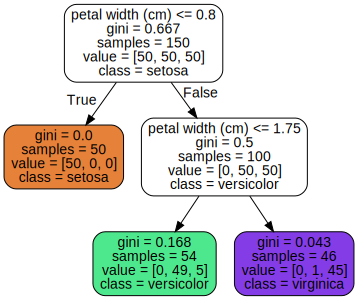

In [2]:
Source.from_file('iris_tree.dot')

**Root node**: the node with depth = 0, at the top

**Child node**: a node at depth >= 1

**Leaf node**: a node without any child nodes


- Decision trees don't require feature scaling / centering

- The above is a **binary tree**: each node can only have 2 children

**White box model**: intuitive models that are easy to interpret & explain how a particular decision was made

**Black box model**: e.g. random forest, NN: hard to explain in simple terms why a particular prediction was made

Basically does simple "cuts" in phase space, dividing it down into square (hypercube) elements.

# CART

**CART**: Classification and Regression Tree, algo to train ("**grow**") a DT.

- Split the training set into 2 subsets using a single feature $k$, and a threshold $t_k$ (e.g. petal width <= 0.8)

- Recursively split the subsets until it reaches a maximum depth, or cannot find a split to improve the "purity". Other stopping conditions possible: minimum # samples in a leaf;  minimum # samples for a ndoe to split; the same but as fractions ; the maximum # leaf nodes.

- To determine $k$ and $t_k$, need to find combination that produces the purest subsets (weighted by their sizes), with cost function (remember, smaller = better):

\begin{equation}
J(k, t_k) = \frac{m_{\text{left}}}{m} G_{\text{left}} + \frac{m_{\text{right}}}{m} G_{\text{right}}
\end{equation}

where

- $m_{\text{left}}$ is the number of instances in the left subset
- $G_{\text{left}}$ the impurity of the left subset: $G=0$ is a totally "pure" node (i.e. all instances are from the same class)

(similarly for right subset).

The "impurity" can be measured in a few different ways:

**Gini impurity**

For the $i$th node

\begin{equation}
G_i = 1 - \sum_{k=1}^n p_{i,k}^2
\end{equation}

where $p_{i,k}$ is the ratio of instances of class $k$ in node $i$ to the total number of instances in node $i$, where the sum runs over all $n$ classes.

**The intuition about Gini impurity**: a way to quantify the probability that, for a given node, if you pick a sample randomly, and a label randomly, what is the probability you **mis**classify them (i.e. label != object).

Then the probability is 

\begin{equation}
\sum_{k=1}^n p_{i,k}(1-p_{i, k}) = \sum_{k=1}^n p_{i,k} - p_{i, k}^2 = 1 - \sum_{k=1}^n p_{i,k}^2
\end{equation}

since by definition

\begin{equation}
\sum_{k=1}^n p_{i,k} = 1
\end{equation}

**Entropy**

\begin{equation}
H_i = - \sum_{k=1}^n p_{i,k} \log_2(p_{i,k})
\end{equation}

where $p_{i,k}$ is the ratio of instances of class $k$ in node $i$ to the total number of instances in node $i$, where the sum runs over all $n$ classes.

Entropy is 0 when a set only contains instances from one class. From information theory: measure of the average information content of a message - if 0, then all messages are the same, c.f. KL divergence & cross-entropy.

Use `criterion="Entropy"` in ctor.

In reality, gives very similar result to Gini impurity.

**Class probabilities**

The DT can be used to estimate the probability an instance belongs to a certain class: find the leaf node for this instance, then find the fraction of training instances with the same class $k$ in that leaf node.

Note that traversing the tree requires going through $\mathcal(O)(\log_2(m))$ nodes, since they are roughly balanced.


Since each node only has to evaluate one feature, the prediction complexity is independent of the number of features, and only depends on the number of instances.

When training, need to compare all features on all samples at each node, which is $\propto n \times m$. So the total complexity there is $\mathcal{O}(n \times m \log_2(m))$.

# Regularisation hyperparameters

DTs make no assumptions about training data (e.g. linear models assume data has linear relationships).

With enough nodes, will overfit the training data - will keep on dividing.

It's a **Nonparametric model**: # of parameters not defined prior to training (unlike in e.g. linear model)

To avoid overfitting, have various options:

- `max_depth`: limit maximum depth of child nodes

- `min_samples_split`: minimum # samples a node has to have before it can be split

- `min samples_leaf`: minimum # samples a leaf node must have

- `min_weight_fraction_leaf`: like `min_samples_leaf`, but as a fraction

- `max_leaf_nodes`: maximum # of leaf nodes

- `max_features`: maximum # features evaluated at each node for splitting

To reduce overfitting, increase the `max_*` params, or decrease `max_*` params.

Can also do **Pruning**: remove unnecessary nodes after training. Decided by testing if removal of node with leaf node children would not statistically significantly affect the purity (use chi2 test).

# Regression

Can use DT to perform regression, based on average target value of the training instances in a given node.

Generate some quadratic data

In [15]:
from sklearn.tree import DecisionTreeRegressor

In [20]:
X = np.random.random(100)

In [52]:
y = 2*X*X - 2*X + 0.5 + 0.1*np.random.random(X.shape)

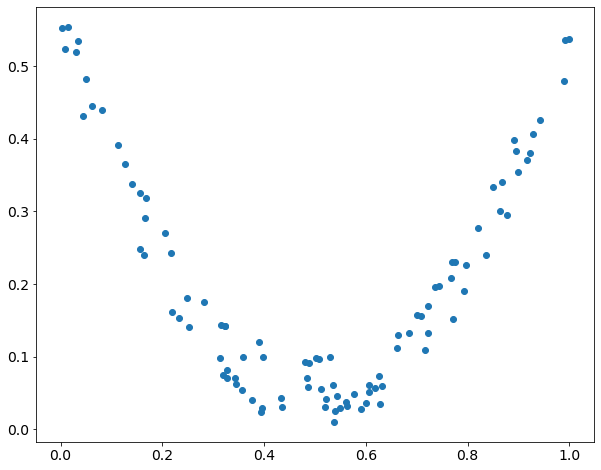

In [61]:
plt.scatter(X, y)

In [78]:
tree_reg = DecisionTreeRegressor(max_depth=3)
tree_reg.fit(X.reshape(-1, 1), y.reshape(-1, 1))

DecisionTreeRegressor(max_depth=3)

In [79]:
export_graphviz(
    tree_reg,
    out_file='tree_reg.dot',
    rounded=True,
    filled=True
)

In [4]:
# !dot -Tpng tree_reg.dot -o tree_reg.png

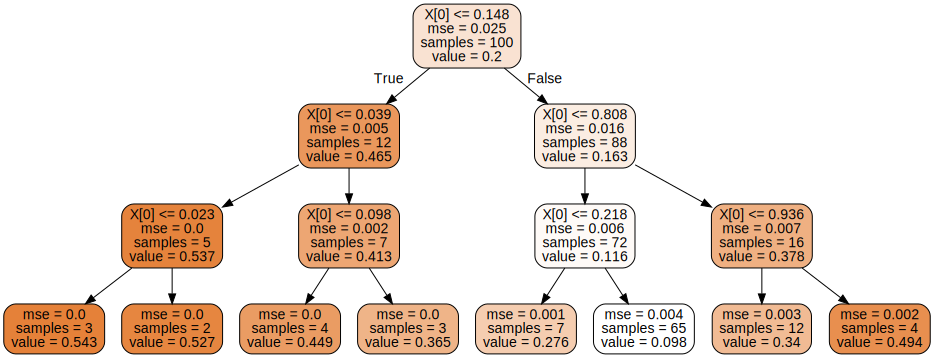

In [3]:
Source.from_file('tree_reg.dot')

Text(0.5, 1.0, 'max_depth=3')

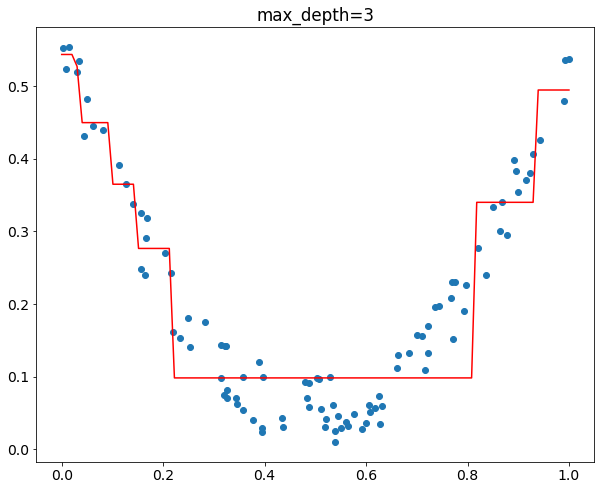

In [81]:
plt.scatter(X, y)
x1 = np.linspace(0, 1, 100)
y1 = tree_reg.predict(x1.reshape(-1, 1))
plt.plot(x1, y1, 'r-')
plt.title("max_depth=3")

As we can see, for each leaf node it predicts 1 value - so we get a series of "steps". With finer granularity, these become less jumpy, BUT we are more prone to overfitting:

In [82]:
tree_reg2 = DecisionTreeRegressor(max_depth=15)
tree_reg2.fit(X.reshape(-1, 1), y.reshape(-1, 1))

DecisionTreeRegressor(max_depth=15)

Text(0.5, 1.0, 'max_depth=15')

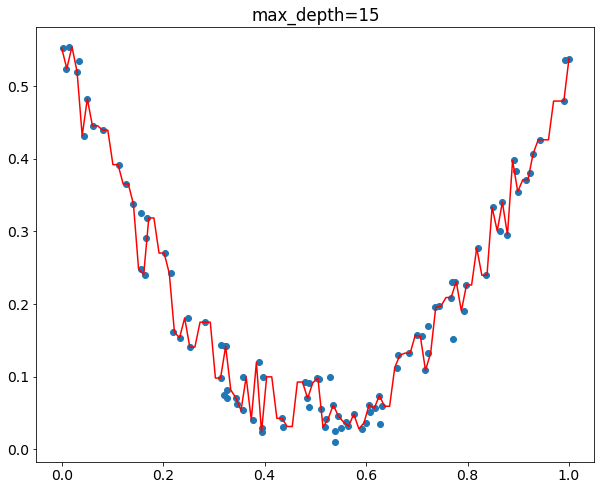

In [84]:
plt.scatter(X, y)
x1 = np.linspace(0, 1, 100)
y1 = tree_reg2.predict(x1.reshape(-1, 1))
plt.plot(x1, y1, 'r-')
plt.title("max_depth=15")

This regression also uses CART, but now it splits to minimise MSE instead of impurity:

\begin{equation}
J = \frac{m_{\text{left}}}{m}\text{MSE}_{\text{left}} + \frac{m_{\text{right}}}{m}\text{MSE}_{\text{right}}
\end{equation}

where

- $\text{MSE}_{\text{left}} = \sum_{i\in \text{node}} (\hat{y}_{\text{node}} - y^{(i)})^2$

- $\hat{y}_{\text{node}} = \frac{1}{m_{\text{node}}} \sum_{i \in \text{node}} y^{(i)}$ (i.e the mean)



# Instability

**All decision boundaries are orthogonal to axes**: sensitive to rotation of data - can solve by PCA to get a better orientation

Can be very sensitive to small variations in training data, esp since training algo is stochastic (randomly selects which features to evaluate at each node).

Random forests can limit this instability.

# Exercises

## 1. What is an approximate depth of a DT on a training set with 1M instances?

Depth is roughly $log_2(m)$, so expect a depth of

In [86]:
np.round(np.log2(1E6))

20.0

## 2. Is a node's Gini impurity generally lower or greater than its parent's? Generally or always?

Generally should be lower than its parents - however could have situations in which one child has a higher impurity but a smaller fraction of the samples? If the other node has more samples and a lower impurity, it would make the split.

## 3. If a DT is overfitting, should you reduce max_depth?

Yes, worth trying

## 4. If a DT is underfitting, should you scale features?

No, DTs are scale-invariant

## 5. If it takes 1 hour to train a DT on m=1E6, how long will it take to train another tree with m=1E7?

Expect it to follow $\mathcal{O}(n \times m \log_2 (m)):

In [88]:
(1E7 * np.log2(1E7) )/ (1E6 * np.log2(1E6))

11.666666666666666

So about 11-12 hours

## 6. If your training set has m = 1E5, will using presort speed up training?

No - presort only speeds up if a few thousand instances. This will slow it down instead.

## 7. Train & fine-tune a DT for moons dataset

In [89]:
from sklearn.datasets import make_moons

In [90]:
?make_moons

In [91]:
X, y = make_moons(n_samples=10000, noise=0.4)

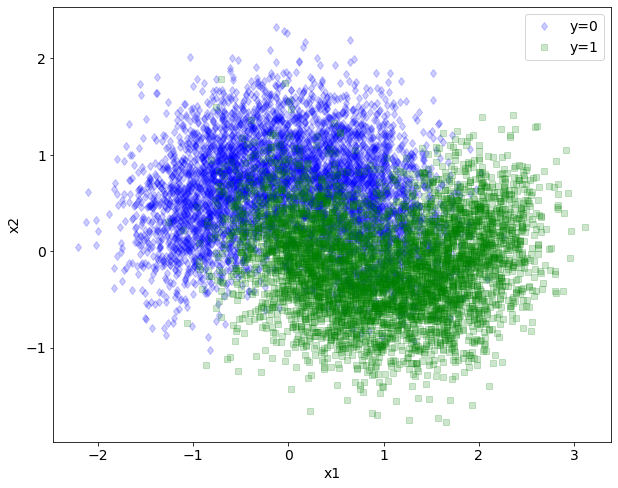

In [99]:
plt.plot(X[y==0][:,0], X[y==0][:,1], 'bd', label='y=0', alpha=0.2)
plt.plot(X[y==1][:,0], X[y==1][:,1], 'gs', label='y=1', alpha=0.2)
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend();

In [95]:
from sklearn.model_selection import train_test_split

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [102]:
X_test.shape

(2000, 2)

In [144]:
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [145]:
from sklearn.metrics import accuracy_score

In [146]:
accuracy_score(dt.predict(X_train), y_train)

0.857625

In [147]:
def draw_decision_regions(clf, x1_min, x1_max, x2_min, x2_max):
    x1 = np.linspace(x1_min, x1_max, 100)
    x2 = np.linspace(x2_min, x2_max, 100)
    X1, X2 = np.meshgrid(x1, x2)
    yy = clf.predict(np.c_[X1.ravel(), X2.ravel()])
    plt.contourf(X1, X2, yy.reshape(X1.shape), cmap='Wistia', alpha=0.75)

Text(0.5, 1.0, 'max_depth=5')

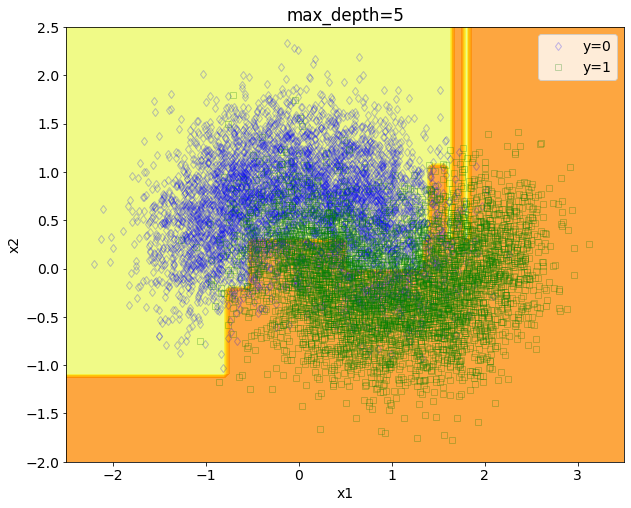

In [149]:
plt.plot(X[y==0][:,0], X[y==0][:,1], 'bd', label='y=0', alpha=0.25, fillstyle='none')
plt.plot(X[y==1][:,0], X[y==1][:,1], 'gs', label='y=1', alpha=0.25, fillstyle='none')
draw_decision_regions(dt, -2.5, 3.5, -2, 2.5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend();
plt.title('max_depth=5')

Not amazing accuracy, and note that there are some weird features even with a relatively small depth (expect ~ 13 generations for 1E4 samples)

In [150]:
np.log2(len(X))

13.287712379549449

In [151]:
from sklearn.model_selection import GridSearchCV

In [176]:
params = {
    'max_depth': np.arange(2, 102, 4),
    'max_leaf_nodes': np.arange(2, 50, 2),
    'min_samples_split': [2, 3, 4]
}

dt_clf = DecisionTreeClassifier(random_state=42)
clf = GridSearchCV(dt_clf, params, cv=5, n_jobs=2, verbose=1, return_train_score=True)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 7500 candidates, totalling 37500 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=2,
             param_grid={'max_depth': array([  2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,  26,
        28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,  52,
        54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,  78,
        80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100]),
                         'max_leaf_nodes': array([  2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,  26,
        28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,  52,
        54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,  78,
        80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100]),
                         'min_samples_split': [2, 3, 4]},
             return_train_score=True, verbose=1)

In [177]:
clf.best_params_

{'max_depth': 8, 'max_leaf_nodes': 28, 'min_samples_split': 2}

In [178]:
best_dt = clf.best_estimator_
# we don't need to retrain on the whole X_train, so long as refit=True was used for GridSearchCv, since it does the retraining for us
print('training:', accuracy_score(best_dt.predict(X_train), y_train))
print('test:', accuracy_score(best_dt.predict(X_test), y_test))

training: 0.8685
test: 0.855


Text(0.5, 1.0, 'best dt')

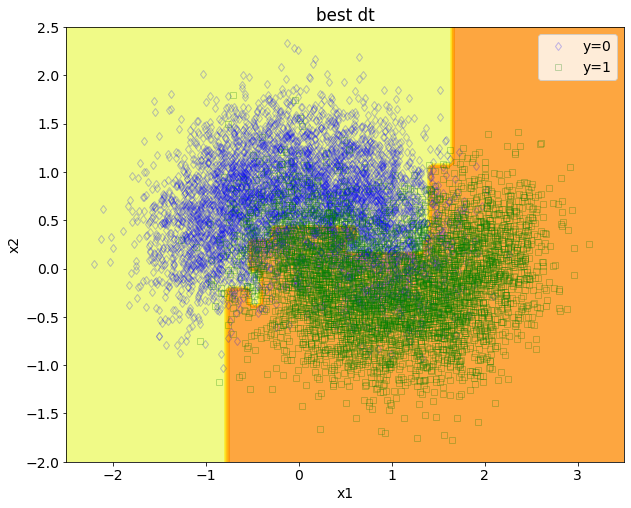

In [179]:
plt.plot(X[y==0][:,0], X[y==0][:,1], 'bd', label='y=0', alpha=0.25, fillstyle='none')
plt.plot(X[y==1][:,0], X[y==1][:,1], 'gs', label='y=1', alpha=0.25, fillstyle='none')
draw_decision_regions(best_dt, -2.5, 3.5, -2, 2.5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend();
plt.title('best dt')

In [180]:
# this is the best one acc to the book?
dt_clf = DecisionTreeClassifier(random_state=42, max_leaf_nodes=17)
dt_clf.fit(X_train, y_train)
print('training:', accuracy_score(dt_clf.predict(X_train), y_train))
print('test:', accuracy_score(dt_clf.predict(X_test), y_test))

training: 0.86225
test: 0.8545
